# Model Selection<br><sub>and Information Sharing and Information Criterion</sub>


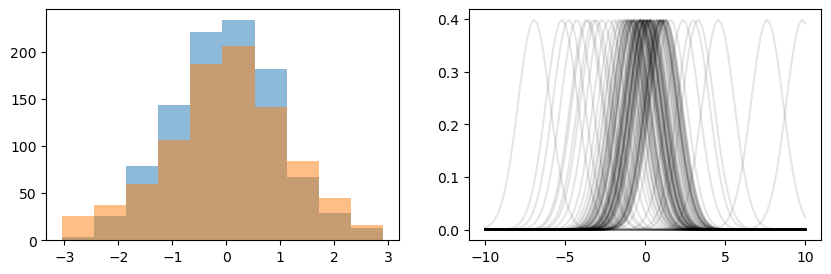

In [249]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

t = 1000
x = stats.norm().rvs(t)
y = stats.t(df=2).rvs(t)

fig,ax = plt.subplots(1,2, figsize=(10,3))
barh,bins,arts=ax[0].hist(x, alpha=0.5)
ax[0].hist(y, bins=bins, alpha=0.5)
#ax[0].set_yscale('log')

support = np.linspace(-10,10,100)
for i in range(100):
    ax[1].plot(support, stats.norm(loc=y[i],scale=1).pdf(support), 
               'k', alpha=0.1)

In [250]:
# t_df=2 samples have larger magnitude
(np.abs(y)>np.abs(x)).mean()-0.5

0.06699999999999995

In [251]:
# fraction of standarized normal > 3
(np.abs(x)>3).mean()

0.001

In [252]:
import pymc as pm

with pm.Model() as spike_and_slab:
    
    p = pm.Beta('p', alpha=1, beta=1)
    spike = pm.Bernoulli('spike', p=p, shape=t)
    slab = pm.Normal('slab', mu=0, sigma=100, shape=t)
    test = pm.Normal('test', mu=spike*slab, sigma=1, observed=y)
    
    idata = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, slab]
>BinaryGibbsMetropolis: [spike]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


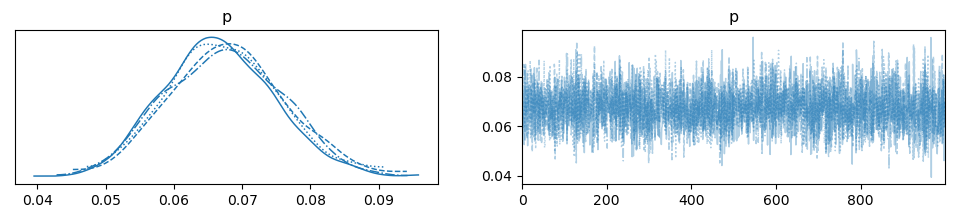

In [253]:
import arviz as az

az.plot_trace(idata, var_names='p');

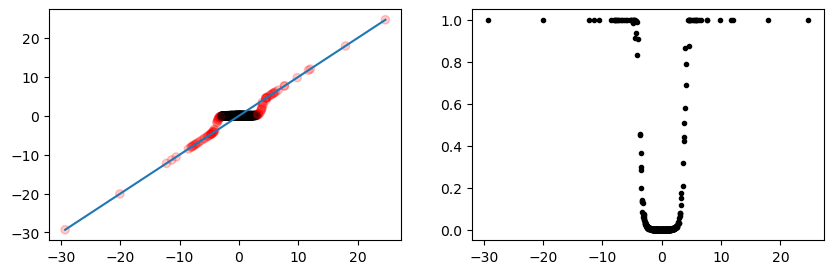

In [254]:
fig,ax = plt.subplots(1,2,figsize=(10,3))

c,d = idata.posterior['slab'].values.shape[:2]

outlier = (np.abs(y)>3)
col = ['r' if o else 'k' for o in outlier]
ax[0].plot([y.min(),y.max()], [y.min(),y.max()])
ax[0].scatter(y,
              (idata.posterior['slab'].values.reshape(c*d,t)*
               idata.posterior['spike'].values.reshape(c*d,t)).mean(axis=0),
              color=col, alpha=0.2)

ax[-1].plot(y,
            idata.posterior['spike'].values.reshape(c*d,t).mean(axis=0),'k.');

In [261]:
with pm.Model() as horseshoe:    
    
    tau_0 = 0.1  # pm.Beta('p_non0', alpha=1, beta=1) 
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=t)
    mu_ = pm.Normal('mu_', mu=0, sigma=1, shape=t)
    mu = pm.Deterministic('mu', mu_*tau*lambdas)
    test = pm.Normal('test', mu=mu, sigma=1, observed=y)

    idata2 = pm.sample()    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lambdas, mu_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 753 divergences after tuning. Increase `target_accept` or reparameterize.


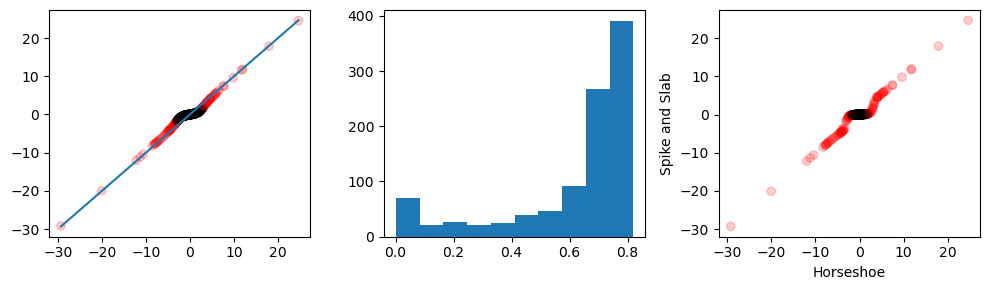

In [262]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

outlier = (np.abs(y)>3)
col = ['r' if o else 'k' for o in outlier]
ax[0].plot([y.min(),y.max()], [y.min(),y.max()])
ax[0].scatter(y,
              idata2.posterior['mu'].values.reshape(c*d,t).mean(axis=0),
              color=col, alpha=0.2)

ax[1].hist(1/(1+(idata2.posterior['tau'].values*
                 idata2.posterior['lambdas'].values).reshape(c*d,t).mean(axis=0)**2));

ax[2].scatter(idata2.posterior['mu'].values.reshape(c*d,t).mean(axis=0),
              (idata.posterior['slab'].values.reshape(c*d,t)*
               idata.posterior['spike'].values.reshape(c*d,t)).mean(axis=0),
              color=col, alpha=0.2)
ax[2].set_ylabel("Spike and Slab")
ax[2].set_xlabel("Horseshoe")

plt.tight_layout()

## Bayesian Occam's Razor

$\begin{align*}
\Pr(M|x) &\propto{} \int f(x|\theta,M) p(\theta|M) p(M) d \theta\\
\Pr(M[u_i=0]|y_i) &\propto{} \int N(y_i|0,1) (1-p)^{1-u_i} p(p) dp = \int_0^1 N(y_i|0,1) (1-p)^1 dp = N(y_i|0,1)\\
\Pr(M[u_i=1]|y_i) &\propto{} \int\int N(y_i|\theta,1) N(\theta|0,100) p^{u_i} p(p) dp d\theta = \int N(y_i|\theta,1) N(\theta|0,100) d\theta \\
\end{align*}$

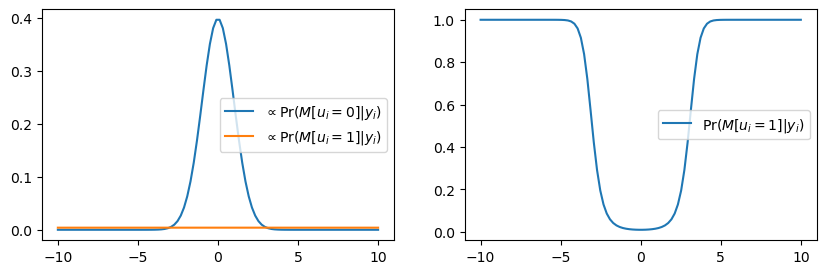

In [263]:
from scipy import integrate

def Pr_M_u_0(y):
    return stats.norm(0,1).pdf(y)

@np.vectorize
def Pr_M_u_1(y):
    return integrate.quad(lambda 𝜃: stats.norm(𝜃,1).pdf(y)*stats.norm(0,100).pdf(𝜃), 
                          -500, 500)[0]

fig,ax = plt.subplots(1,2,figsize=(10,3))

support = np.linspace(-10,10,100)
Pr_M_u_0_ = Pr_M_u_0(support)
Pr_M_u_1_ = Pr_M_u_1(support)

ax[0].plot(support, Pr_M_u_0_, label="$\\propto \\Pr(M[u_i=0]|y_i)$")
ax[0].plot(support, Pr_M_u_1_, label="$\\propto \\Pr(M[u_i=1]|y_i)$")
ax[0].legend()

ax[1].plot(support, Pr_M_u_1_/(Pr_M_u_1_+Pr_M_u_0_), label="$\\Pr(M[u_i=1]|y_i)$")
ax[1].legend();


The **Bayesian Occam's razor** phenomenon is a **curse of (parameter) dimensionality** which encourages simpler models to have larger marginal likelihoods than more complex models. We can generally expect that

$$p(\mathbf{x}|M_{\theta}) = \int f(\mathbf{x}|\theta) p(\theta)d\theta > \int\int f(\mathbf{x}|\theta, \eta) p(\theta, \eta) d\theta d\eta = p(\mathbf{x}|M_{\theta, \eta})$$

because the density of the prior $p(\theta, \eta)$ must be reduced to in relation to the increased volume in increasingly higher demensional (parameter) space.

---

Marginal likelihoods are small if
- prior specification are badly non-overlapping with the likelihood
- or if the data model cannot adequately reflect the empirical data distribution

Added model complexity that sufficiently increases likelihood to overcome the **Bayesian Occam's razor** penalization on the marginal likelihood would seem to be justified, but what of decreasing marginal likelihoods with increasing model complexity?

- The **Bayesian Occam's razor** is not a model selection tool because it depends on how well-aligned the prior is to the likelihood (data)
- What the **Bayesian Occam's razor** shows is that priors have increasingly influential effects in higher dimesions, and prior-data conflict in increasingly higher dimensions is increasingly problematic

    


## Bayes Factors

$K = \frac{p(\mathbf{x}|M_1)}{p(\mathbf{x}|M_0)} = \frac{p(M_1|\mathbf{x})}{p(M_0|\mathbf{x})} \frac{p(M_0)}{p(M_1)}$ is often proposed as a model comparison tool with evidence in favor of $M_1$ over $M_0$ given as 

|log10 K|	K|	Strength of evidence |
|-|-|-|
|0 to 1/2	|1 to 3.2	| Anecdotal|
|1/2 to 1	|3.2 to 10	| Substantial |
|1 to 2	|10 to 100 |	Strong|
|> 2|	> 100	|Decisive|
    
For fair "apples to apples" comparisons Bayes Factors might be reasonably useful.

For example, the **Savage-Dickey density ratio** for the special case where $M_1$ is a  (nested model) version of $M_0$ where the parameter value $\theta = \theta_1$ is the ratio of the **posterior** and the **prior** evaluated at $\theta=\theta_1$ 

$$
\begin{align*}
p(\mathbf{x}|M_1) ={}& \int p(\mathbf{x},\eta | M_1)d\eta\\
 ={}& \int p(\mathbf{x},\eta|\overbrace{\theta=\theta_1, M_0}^{=M_1}) d\eta = p(\mathbf{x}|\theta=\theta_1, M_0)\\
\frac{p(\mathbf{x}|M_1)}{p(\mathbf{x}|M_0)} ={}& \frac{p(\mathbf{x}|\theta=\theta_1, M_0)}{p(\mathbf{x}|M_0)} = \frac{\frac{p(\theta=\theta_1|\mathbf{x}, M_0) p(\mathbf{x}| M_0)}{p(\theta=\theta_1|M_0)}}{p(\mathbf{x}|M_0)}\\ ={}& \frac{p(\theta=\theta_1|\mathbf{x}, M_0)}{p(\theta=\theta_1|M_0)}
\end{align*}$$



## Bayesian Information Sharing

Returning to our initial variable selection considerations...

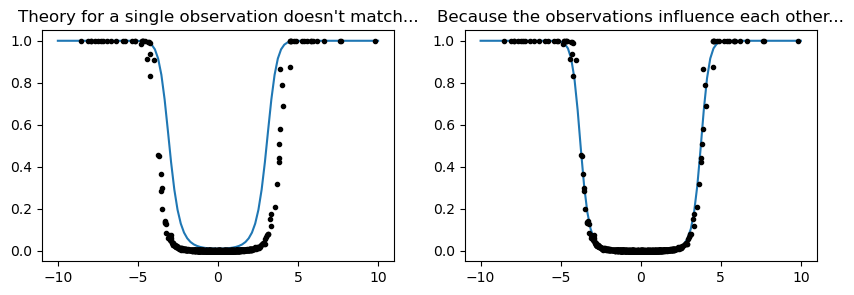

In [264]:
fig,ax = plt.subplots(1,2,figsize=(10,3))

bounds = np.abs(y)<10

ax[0].plot(support, (Pr_M_u_1_/(Pr_M_u_1_+Pr_M_u_0_)), label="$\\Pr(M[u_i=0]|y_i)$")
ax[0].plot(y[bounds],
           idata.posterior['spike'].values.reshape(c*d,t).mean(axis=0)[bounds],'k.');
ax[0].set_title("Theory for a single observation doesn't match...")

ax[1].plot(support, (.08*Pr_M_u_1_/(.08*Pr_M_u_1_+.92*Pr_M_u_0_)), label="$\\Pr(M[u_i=0]|y_i)$")
ax[1].plot(y[bounds],
           idata.posterior['spike'].values.reshape(c*d,t).mean(axis=0)[bounds],'k.');
ax[1].set_title("Because the observations influence each other...");


### Mixture Models 

A very simple form of information sharing...

$$\scriptsize
\begin{align*}
x_i \sim {} & \sum_{k=1}^K \mathbf{v}_{ik} \mathcal N (\mu_k,\sigma_k^2) & \mu_k \sim {} & \mathcal N (\mu_{k0},\sigma_{k0}^2) \quad \sigma_k^2 \sim \text{Inverse-Gamma} (\alpha_{k0}, \beta_{k0})\\
\overset{\overset{\text{multinomial}}{\mathbf{v}_i\,\sim\,\text{MN}}(\mathbf{p}, \,n=1)}{\Pr(\mathbf{v}_i|E[\mathbf{v}_i]=\mathbf{p}, n=1)} = {}& \frac{n!}{v_1!\cdots v_K!} p_1^{\mathbf{v}_{i1}} \cdots p_K^{\mathbf{v}_{iK}}  & \sum_{j=1}^n \mathbf{v}_{ik} = {}& 1 \quad \mathbf{v}_{ik} \in \{0,1\} \quad \text{latent (unknown) subpulation membership $\textbf{v}$} \\
\underset{\text{Dirichlet}}{\overset{p\,\sim\,\text{Dir}(\boldsymbol \alpha)}{p\left(\mathbf{p}|\boldsymbol \alpha \right)}} = {}& {\frac {1}{\mathrm {B} ({\boldsymbol {\alpha }})}}\prod _{k=1}^{K}p_{k}^{\alpha _{k}-1} & \sum_{j=1}^np_k = {}& 1 \quad {\displaystyle \mathrm {B} ({\boldsymbol {\alpha }})= \prod \limits _{k=1}^{K}\Gamma (\alpha _{k}) \bigg/ \Gamma \left(\sum \limits _{k=1}^{K}\alpha _{k}\right)} \quad E[p_k] = \alpha_k\bigg/\sum_{k=1}^K \alpha_k 
\end{align*}$$

$$\scriptsize
\begin{align*}
p(\mu_k | -) \propto {} & \mathcal N (\mu_k| \mu_{k0},\sigma_{k0}^2) \prod_{i=1}^n \sum_{k=1}^K\mathbf{v}_{ik} \mathcal N (x_i | \mu_k,\sigma_k^2) & p(\sigma_k^2 | -) \propto {} & \underset{\text{Inverse-Gamma}}{\text{IG} (\sigma_k^2|\alpha_{k0}, \beta_{k0})} \prod_{i=1}^n \sum_{k=1}^K\mathbf{v}_{ik} \mathcal N (x_i|\mu_k,\sigma_k^2)
\end{align*}$$$$\scriptsize
\begin{align*}
\Pr(\mathbf{v}_{ik}=1|-) \propto {} & p_1^{\mathbf{v}_{i1}} \cdots p_K^{\mathbf{v}_{iK}} \sum_{k=1}^K\mathbf{v}_{ik} \mathcal N (x_i | \mu_k,\sigma_k^2) & p(\mathbf{p}| - ) \propto {}& \prod _{k=1}^{K}p_{k}^{\alpha _{k}-1} \prod_{i=1}^{n} p_1^{\mathbf{v}_{i1}} \cdots p_K^{\mathbf{v}_{iK}}
\end{align*}$$

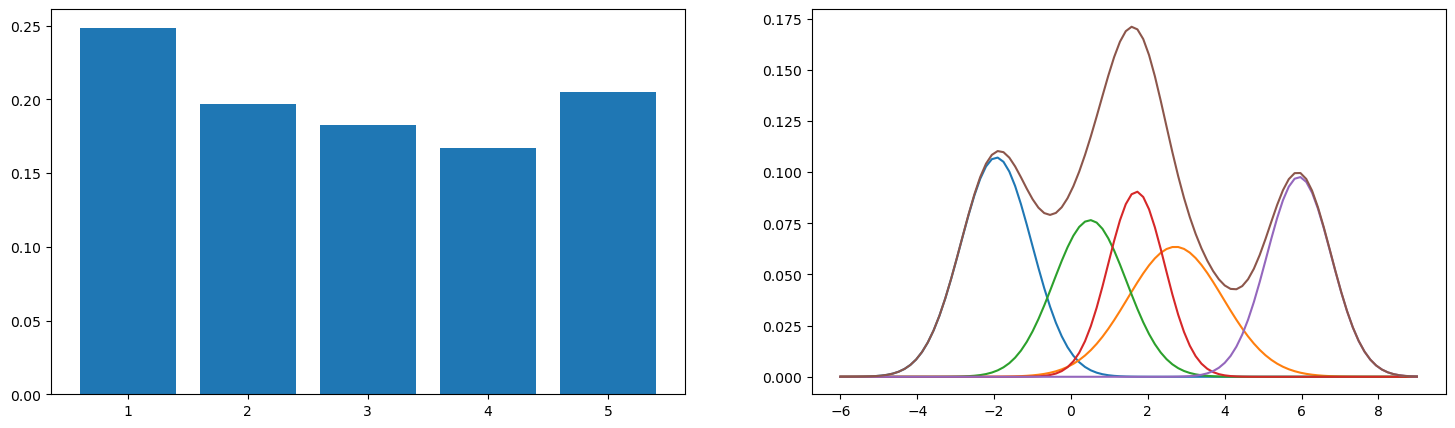

In [265]:
np.random.seed(9)

k = 5
alpha = [2]*k
p_true = stats.dirichlet(alpha).rvs(1)[0] # p_true.sum() # 1

mu_k_true = stats.norm(0,3).rvs(k)
support = np.linspace(-6,9,100)
population_pdf = 0*support
sigma2_k_true = stats.halfnorm().rvs(k)

fig,ax = plt.subplots(1,2,figsize=(18,5))
ax[0].bar(x=np.linspace(1,5,5), height=p_true)
for j in range(k):
    subpopulation_pdf = p_true[j]*stats.norm(mu_k_true[j],sigma2_k_true[j]**0.5).pdf(support)
    ax[1].plot(support, subpopulation_pdf); population_pdf += subpopulation_pdf
    
ax[1].plot(support, population_pdf); 

In [266]:
n_ = 1000
v_true = stats.multinomial(n=1,p=p_true).rvs(n_)
v_true[:3,:]

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [267]:
print(mu_k_true)
print((v_true*mu_k_true)[:3,:])
print((v_true*mu_k_true).sum(axis=1)[:3])

[-1.94384238  2.715657    0.49645017  1.70025387  5.93193509]
[[-1.94384238  0.          0.          0.          0.        ]
 [-1.94384238  0.          0.          0.          0.        ]
 [-0.          0.          0.49645017  0.          0.        ]]
[-1.94384238 -1.94384238  0.49645017]


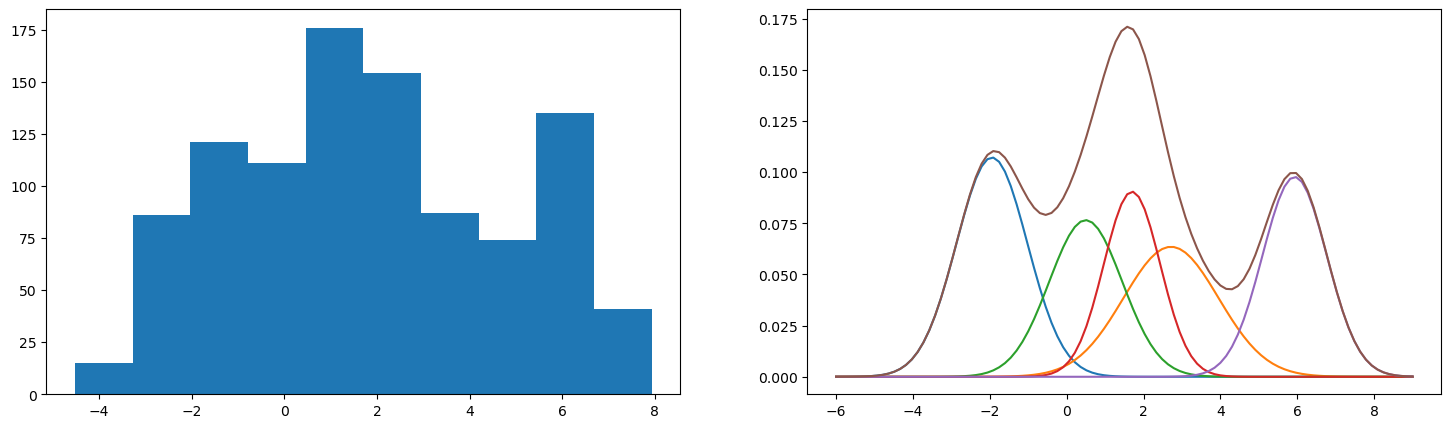

In [268]:
x_ = stats.norm((v_true*mu_k_true).sum(axis=1), (v_true*sigma2_k_true).sum(axis=1)**0.5).rvs()
ax[0].hist(x_)
fig

### Hierachical (more than random effects) Models

A more interesting form of information sharing...


In [294]:
n = 100
mu = np.sort(stats.norm(0,1).rvs(n))
r = 5
# create correlated observations
y = stats.norm(mu,1).rvs((r,n))
ndx = y.astype(int)
for j in range(100):
    ndx[:,j] = j

np.round(np.corrcoef(y),2)


array([[1.  , 0.49, 0.52, 0.59, 0.61],
       [0.49, 1.  , 0.43, 0.59, 0.54],
       [0.52, 0.43, 1.  , 0.54, 0.55],
       [0.59, 0.59, 0.54, 1.  , 0.56],
       [0.61, 0.54, 0.55, 0.56, 1.  ]])

In [281]:
# Decorrelation by within group estimation
# with independent priors
with pm.Model() as MixEff:
    
    m = pm.Normal('m', mu=0, sigma=10, shape=n)
    s = pm.HalfNormal('s', sigma=10, shape=n)
    
    x = pm.Normal('x', mu=m[ndx.flatten()], 
                       sigma=s[ndx.flatten()], 
                  observed=y.flatten())
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


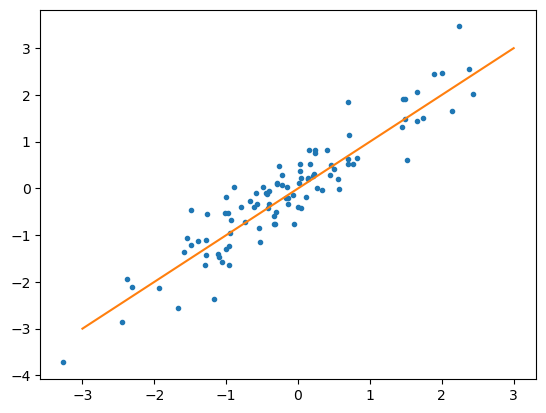

In [282]:
c,d = idata.posterior.m.shape[:2]
plt.plot(mu, idata.posterior.m.values.reshape(c*d,n).mean(axis=0), '.')
plt.plot([-3,3],[-3,3]);


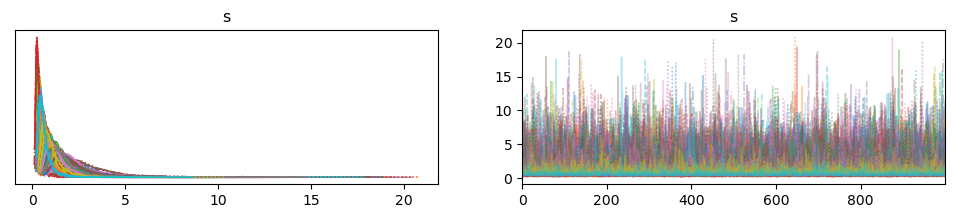

In [283]:
az.plot_trace(idata, var_names='s');

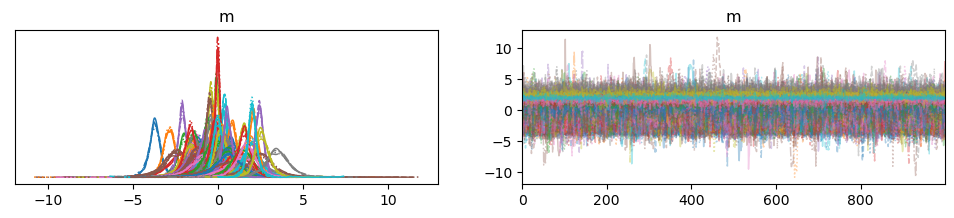

In [284]:
az.plot_trace(idata, var_names='m');

In [285]:
# Decorrelation by within group estimation
# with common hierarchical priors
with pm.Model() as MixEff2:
    
    m_s = pm.HalfNormal('m_s', sigma=10)
    m_ = pm.Normal('m_', mu=0, sigma=m_s)
    m = pm.Normal('m', mu=m_, sigma=m_s, shape=n)
    
    s_s = pm.HalfNormal('alpha', sigma=10)
    s_ = pm.HalfNormal('beta', sigma=10)
    s = pm.Gamma('s', alpha=s_s, beta=s_, shape=n)
    
    x = pm.Normal('x', mu=m[ndx.flatten()], sigma=s[ndx.flatten()],
                  observed=y.flatten())
    
    idata2 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_s, m_, m, alpha, beta, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


0.845431846649835 0.32821579304998943


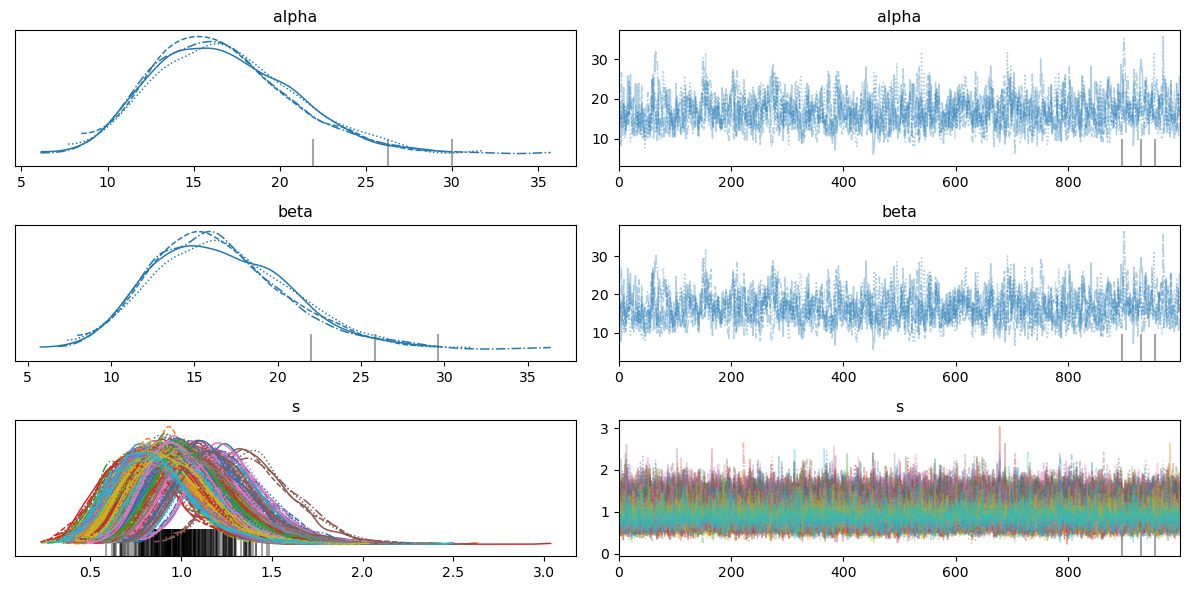

In [286]:
az.plot_trace(idata2, var_names=['alpha','beta','s'])
plt.tight_layout()
print(y.std(axis=0).mean(),y.std(axis=0).std())

-0.08998396126382906 1.2212750177343392


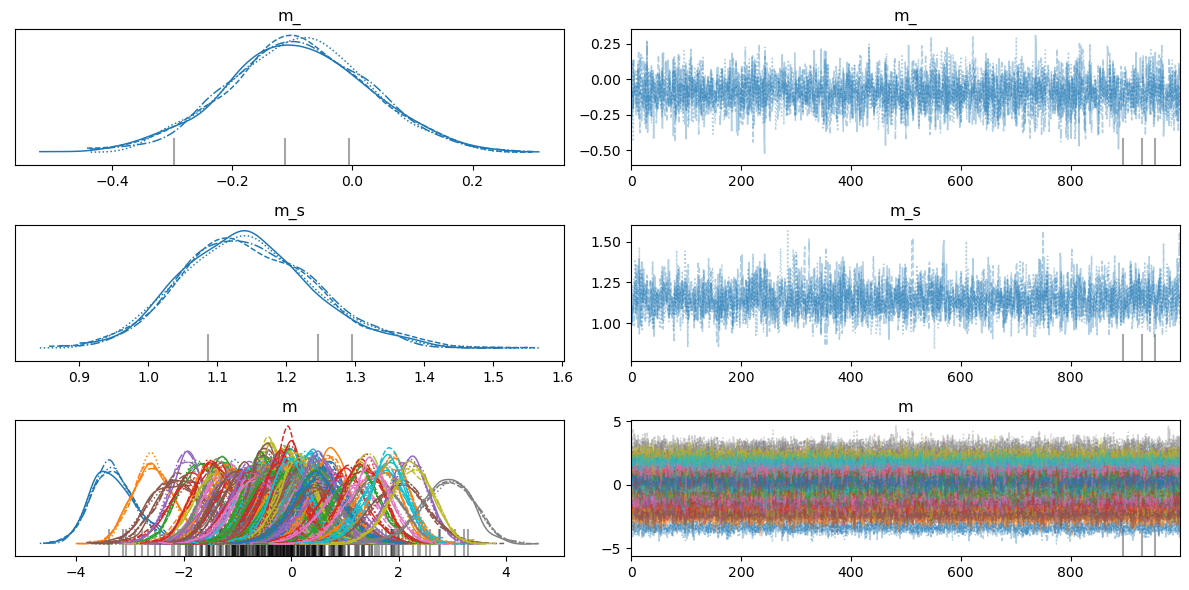

In [287]:
az.plot_trace(idata2, var_names=['m_','m_s','m'])
plt.tight_layout()
print(y.mean(axis=0).mean(),y.mean(axis=0).std())

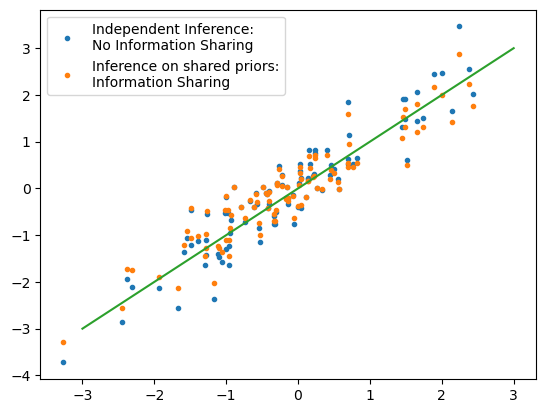

In [288]:
c,d = idata2.posterior.m.shape[:2]
plt.plot(mu, idata.posterior.m.values.reshape(c*d,n).mean(axis=0),
         '.', label="Independent Inference:\nNo Information Sharing")
plt.plot(mu, idata2.posterior.m.values.reshape(c*d,n).mean(axis=0),
         '.', label="Inference on shared priors:\nInformation Sharing")
plt.plot([-3,3],[-3,3])
plt.legend();

In [289]:
((mu-idata.posterior.m.values.reshape(c*d,n).mean(axis=0))**2).sum()**0.5         

4.5438030583289395

In [290]:
((mu-idata2.posterior.m.values.reshape(c*d,n).mean(axis=0))**2).sum()**0.5

4.134942351033418

In [295]:
# What we've learned
with pm.Model() as MixEff3:
    
    m = pm.Normal('m', mu=0, sigma=1, shape=n)
    s = pm.Gamma('s', alpha=16,beta=16, shape=n)
    
    x = pm.Normal('x', mu=m[ndx.flatten()], sigma=s[ndx.flatten()], 
                  observed=y.flatten())
    
    idata3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


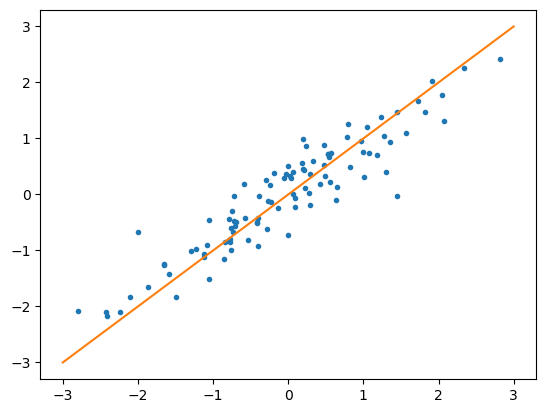

In [296]:
c,d = idata.posterior.m.shape[:2]
plt.plot(mu, idata3.posterior.m.values.reshape(c*d,n).mean(axis=0), '.')
plt.plot([-3,3],[-3,3]);


In [297]:
((mu-idata3.posterior.m.values.reshape(c*d,n).mean(axis=0))**2).sum()**0.5         

4.133064808388719

In [298]:
# Something hacky just to show more information sharing
with pm.Model() as MixEff4:
    
    m = pm.Normal('m', mu=0, sigma=1, shape=n+4)
    s = pm.Gamma('s', alpha=16,beta=16, shape=n+4)
    
    x = pm.Normal('x', mu=(m[ndx.flatten()]+m[ndx.flatten()+1]+m[ndx.flatten()+2]+m[ndx.flatten()+3]+m[ndx.flatten()+4])/5, 
                       sigma=(s[ndx.flatten()]+s[ndx.flatten()+1]+s[ndx.flatten()+2]+s[ndx.flatten()+3]+s[ndx.flatten()+4])/5, 
                  observed=y.flatten())
    
    idata4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


0.0016847382080332496 1.1903593483791899


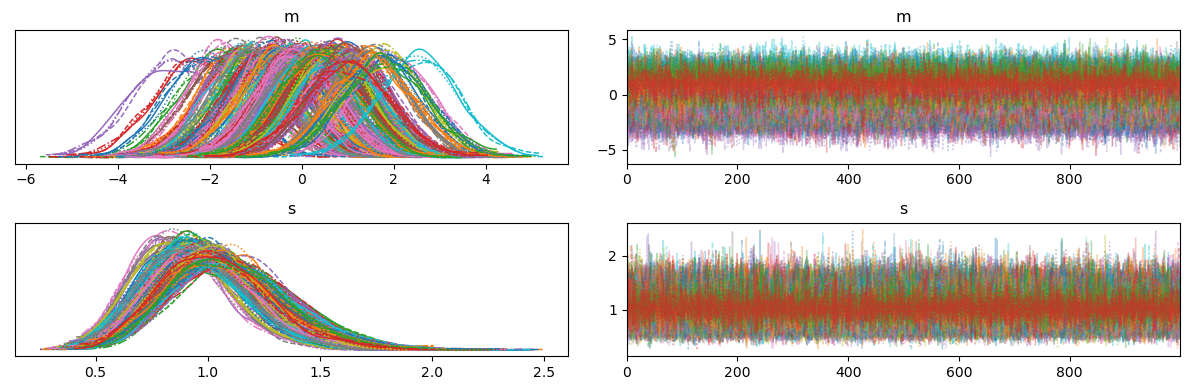

In [299]:
az.plot_trace(idata4, var_names=['m','s'])
plt.tight_layout()
print(y.mean(axis=0).mean(),y.mean(axis=0).std())

In [300]:
idata2.posterior['m'].values.reshape(c*d,n).std(axis=0)

array([0.44970219, 0.41241095, 0.40037754, 0.49901488, 0.38620833,
       0.5065357 , 0.40668637, 0.49097142, 0.43045347, 0.41604356,
       0.41408611, 0.41012089, 0.39648636, 0.47243573, 0.38635546,
       0.4757433 , 0.44946351, 0.41077893, 0.45545811, 0.41324025,
       0.51757752, 0.44381503, 0.40184481, 0.3990772 , 0.45875447,
       0.45966122, 0.42139978, 0.43452653, 0.34977209, 0.41816743,
       0.47731058, 0.43125867, 0.34820653, 0.41297935, 0.46953183,
       0.44627364, 0.38314592, 0.43686163, 0.3633541 , 0.43988424,
       0.44472408, 0.4010143 , 0.36871022, 0.44868435, 0.40900803,
       0.35583358, 0.45813491, 0.43427502, 0.4233724 , 0.51268919,
       0.40131179, 0.36596765, 0.4372233 , 0.46723547, 0.38386238,
       0.45806371, 0.48384988, 0.39046807, 0.40947736, 0.37059207,
       0.40112327, 0.3925165 , 0.43541106, 0.3816076 , 0.43306851,
       0.40585702, 0.42422591, 0.40924103, 0.46005572, 0.36443438,
       0.40652825, 0.37484203, 0.41949758, 0.33926174, 0.49805

In [301]:
((idata4.posterior['m'].values[:,:,:-4]+
  idata4.posterior['m'].values[:,:,1:-3]+
  idata4.posterior['m'].values[:,:,2:-2]+
  idata4.posterior['m'].values[:,:,3:-1]+
  idata4.posterior['m'].values[:,:,4:])/5).reshape(c*d,n).std(axis=0)

array([0.29930743, 0.26683475, 0.25219448, 0.25311461, 0.25019346,
       0.25334569, 0.25341807, 0.24473937, 0.2433781 , 0.24419584,
       0.24685918, 0.24346956, 0.24305416, 0.23972449, 0.24196941,
       0.24302388, 0.25178664, 0.25145556, 0.24804932, 0.24794644,
       0.24111578, 0.24367173, 0.23604653, 0.23953804, 0.24066388,
       0.24106555, 0.2436739 , 0.24868813, 0.24382708, 0.24169453,
       0.24119594, 0.24083285, 0.23486729, 0.23042052, 0.231693  ,
       0.22641525, 0.23051407, 0.23465874, 0.23636643, 0.24595657,
       0.25206688, 0.25296613, 0.2530466 , 0.25331879, 0.24735048,
       0.24152985, 0.23732257, 0.24324639, 0.24387833, 0.24914718,
       0.24730247, 0.24679143, 0.24403609, 0.24466476, 0.24489594,
       0.23810129, 0.24062111, 0.25098405, 0.25151175, 0.24697165,
       0.24089573, 0.24801082, 0.24513512, 0.24172068, 0.24257699,
       0.24112604, 0.24263449, 0.23622777, 0.2352021 , 0.23307338,
       0.23253991, 0.23619386, 0.24017099, 0.2372838 , 0.24246

In [302]:
mmm = \
((idata4.posterior['m'].values[:,:,:-4]+
  idata4.posterior['m'].values[:,:,1:-3]+
  idata4.posterior['m'].values[:,:,2:-2]+
  idata4.posterior['m'].values[:,:,3:-1]+
  idata4.posterior['m'].values[:,:,4:])/5).reshape(c*d,n).mean(axis=0)

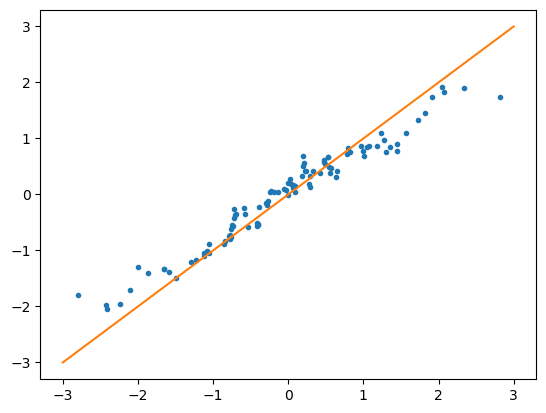

In [303]:
c,d = idata.posterior.m.shape[:2]
plt.plot(mu, mmm, '.')
plt.plot([-3,3],[-3,3]);


In [304]:
((mu-mmm)**2).sum()**0.5

2.922580682469101

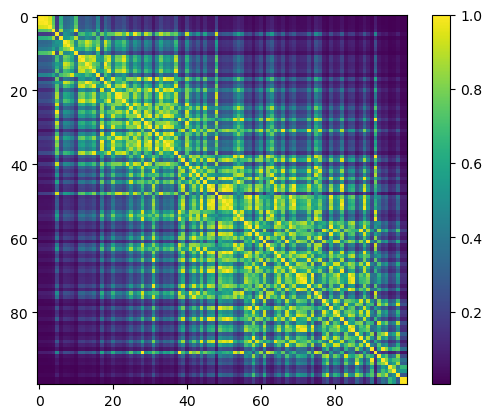

In [311]:
_lambda = .06
sigma2 = 1
K = sigma2*np.exp(-(y.mean(axis=0).reshape(n,1) - 
                    y.mean(axis=0).reshape(1,n))**2/_lambda**2)

alf = 1
K = sigma2*np.exp(-alf*np.abs(y.mean(axis=0).reshape(n,1) - 
                              y.mean(axis=0).reshape(1,n)))

K=(K+K.T)/2  # np.linalg.matrix_rank(K)
plt.imshow(K)
plt.colorbar();

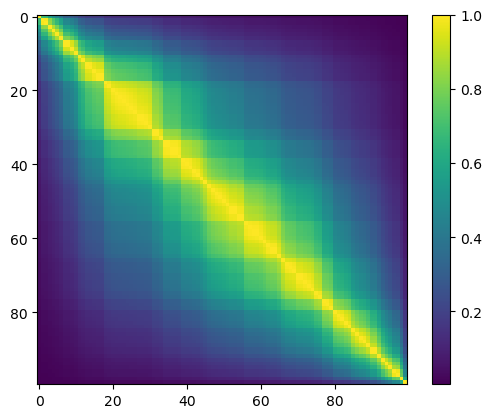

In [307]:
K = sigma2*np.exp(-alf*np.abs(mu.reshape(n,1) - 
                              mu.reshape(1,n)))
K=(K+K.T)/2  # np.linalg.matrix_rank(K)
plt.imshow(K)
plt.colorbar();

In [312]:
# What we've learned
with pm.Model() as MixEff5:
    
    m = pm.MvNormal('m', mu=0, cov=K, initval=y.mean(axis=0))
    s = pm.Gamma('s', alpha=16, beta=16, shape=n)    
    x = pm.Normal('x', mu=m[ndx.flatten()], sigma=s[ndx.flatten()], 
                  observed=y.flatten())
    
    idata5 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


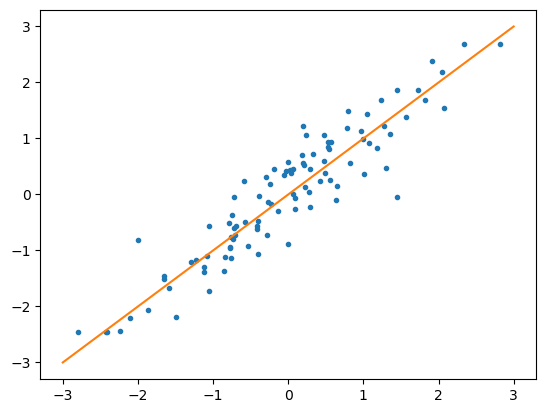

In [313]:
c,d = idata.posterior.m.shape[:2]
plt.plot(mu, idata5.posterior.m.values.reshape(c*d,n).mean(axis=0), '.')
plt.plot([-3,3],[-3,3]);


0.0016847382080332496 1.1903593483791899


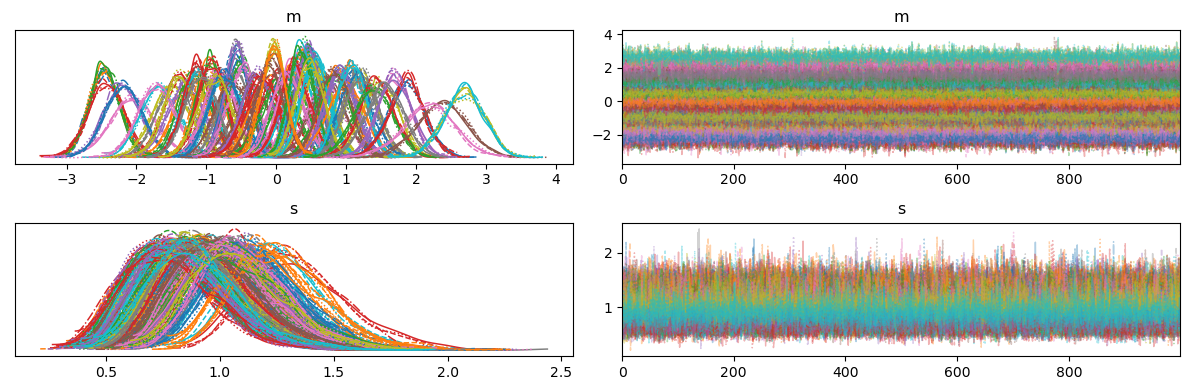

In [314]:
az.plot_trace(idata5, var_names=['m','s'])
plt.tight_layout()
print(y.mean(axis=0).mean(),y.mean(axis=0).std())

In [315]:
((mu-idata5.posterior.m.values.reshape(c*d,n).mean(axis=0))**2).sum()**0.5         

4.3607010819774

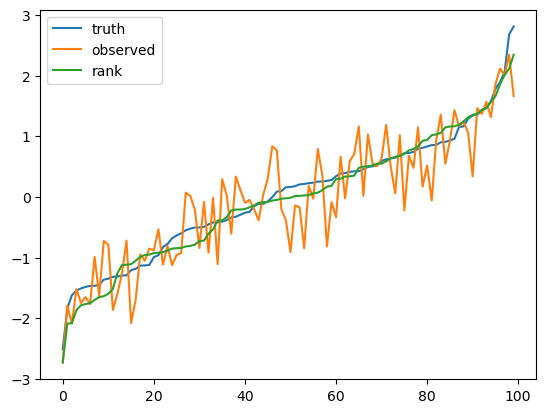

In [82]:
plt.plot(mu, label="truth")
plt.plot(y.mean(axis=0), label="observed")
plt.plot(np.sort(y.mean(axis=0)), label="rank")
plt.legend();

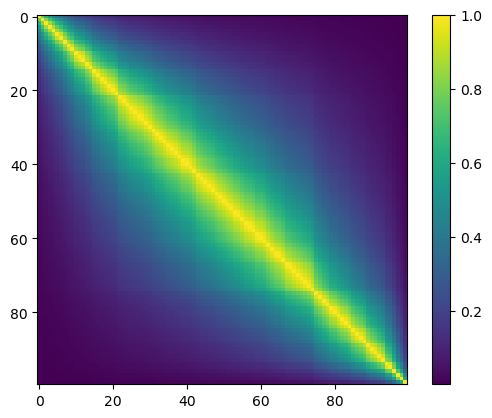

In [316]:
K = sigma2*np.exp(-alf*np.abs(np.sort(y).mean(axis=0).reshape(n,1) - 
                              np.sort(y).mean(axis=0).reshape(1,n)))

K=(K+K.T)/2  # np.linalg.matrix_rank(K)
plt.imshow(K)
plt.colorbar();

In [317]:
# What we've learned
with pm.Model() as MixEff6:
    
    m = pm.MvNormal('m', mu=0, cov=K, initval=y.mean(axis=0))
    s = pm.Gamma('s', alpha=16, beta=16, shape=n)    
    x = pm.Normal('x', mu=m[ndx.flatten()], sigma=s[ndx.flatten()], 
                  observed=y[:,np.argsort(y.mean(axis=0))].flatten())
    
    idata6 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


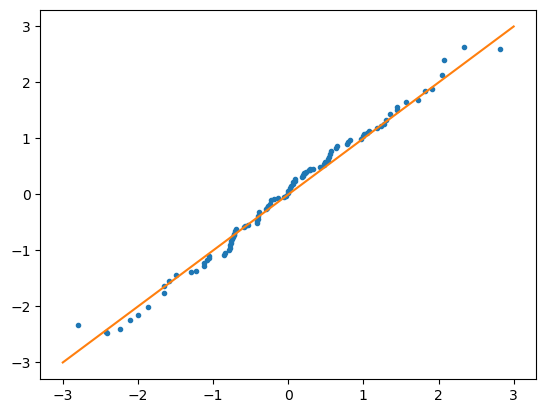

In [318]:
c,d = idata.posterior.m.shape[:2]
plt.plot(mu, idata6.posterior.m.values.reshape(c*d,n).mean(axis=0), '.')
plt.plot([-3,3],[-3,3]);


In [319]:
((mu-idata6.posterior.m.values.reshape(c*d,n).mean(axis=0))**2).sum()**0.5         

1.2699816835381517

## Back to Model Selection

### LRT

The **(nested) log likelihood ratio test (LRT) statistic** is $\quad2\log\left(\frac{p(y|\hat \theta_{M_1})}{p(y|\hat \theta_{M_0)}}\right) = \color{gray}{2(\log(p(y|\hat \theta_{M_1})) - \log(p(y|\hat \theta_{M_0})))} $ 

and has an asymptotically $\;\chi^2_{df}\;$ distribution with **expected value** [equal](https://en.wikipedia.org/wiki/Likelihood-ratio_test) **degrees of freedom**  $\dim(\theta_{M_1})-\dim(\theta_{M_0})$

$$2\log\left(\frac{p(y|X_{n\times p}\hat \beta)}{p(y|\bar y)}\right)\quad \text{is asymptotically} \;\;\chi^2_{p-1}\;\;\text{and a large LRT statistic rejects $M_0$ in favor of $M_1$} $$

> #### Sketch of Some "Intuition" as to Why this is so
> 
> - $p(y|\hat \theta_{M})$ is assymptotically normal 
> - $\frac{p(y|\hat \theta_{M_1})}{p(y|\hat \theta_{M_0})}$ cancels normalizing constants
> - $\log p(y|\hat \theta_{M})$ after canceling normalizing constants, and since one parameter $\theta_i$ perfectly predicts one $\theta_i=y_i$, is $-\frac{1}{2}\sum_{i=1}^{n-\text{dim}(M)+1} \frac{(y_i-\bar y)^2}{\sigma^2} -\frac{1}{2}\sum_{i=1}^{\text{dim}(M)-1} \frac{(y_j-y_j)^2}{\sigma^2}$
> - $E[\frac{(y_i-\bar y)^2}{\sigma^2}] = 1$ so the $-\frac{1}{2}$ term makes difference $\text{dim}(M)-1$ and cancels the scaling $2$

### Deviance  and "Bayesian" Model Size

Model **deviance** is $\quad D(\theta) = 2(\underset{\text{a constant}}{\overset{\text{saturated model}}{\log(p(y|y))}} - \overset{\text{actual model}}{\log(p(y|\theta)})) \color{gray}{= 2\log\left(\frac{p(y|y)}{p(y|\theta)}\right)} \geq 0 \quad$ (scaled by $2$ [to match the LR](https://stats.stackexchange.com/qu,estions/379810/why-is-the-deviance-defined-with-a-factor-2-or-likelihood-ratio-squared))

The [Bayesian characterization](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=d78ad2497639bff740d0c1181c35263d2630b172)
 of the **effective number of parameters** in a model is

$$p_D = {\overline{D(\theta)} - D(\bar{\theta})} \color{gray}{= 2(\log(p(y|\bar{\theta})) - \overline{\log(p(y|\theta))}) \underset{\text{usually}}{\geq 0}} \quad \text{ or } \quad \underset{\text{not typically preferred as it's less stable}}{p_D = 2\text{Var}_{p(\theta|y)}[\log(p(y|\theta))]}$$

because (for fixed models such as ["linear models with uniform prior distributions"](http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf) and large $n$) both versions of $p_D$ estimate the degrees of freedom parameter of the asymptotic $\chi^2_{\text{df}}$ of $\log(p(y|\theta))$ which is the number of parameters $p(y|\theta)$.

> #### Sketch of the "Proof" as to Why this is so
> 
> $-2\log(p(y|\bar{\theta})$ for linear regression is the expected standardized residual sum of squares
> 
> $\begin{align*}
(y-\hat y)^T(y-\hat y)/\sigma^2 &={} y^T(I-H)^T(I-H)y/\sigma^2
= y^T(I-H)(I-H)y/\sigma^2 
= y^T(I-H)y/\sigma^2 \\
&={} (X\beta + \epsilon)^T(I-H)(X\beta + \epsilon)/\sigma^2
= \epsilon^T(I-H)\epsilon/\sigma^2 = \text{trace}(\epsilon^T(I-H)\epsilon/\sigma^2)\\
&={} \text{trace}((I-H)\epsilon\epsilon^T/\sigma^2) = \text{trace}((I-H)\epsilon\epsilon^T/\sigma^2) \\
\text{with expected value} & \quad \; \text{trace}((I-H)\sigma^2I/\sigma^2) = \text{trace}(I-H) = n - \text{trace}(H)\\
&={} n - \text{trace}(X^T(X^TX)^{-1}X) = n - \text{trace}((X^TX)^{-1}XX^T) = n - \text{trace}(I_{p \times p})\\
&={} n - p
\end{align*}$
>
> while $-2\overline{\log(p(y|\theta))}$ does something like reflect the variability of $n-p$ unexplained data points plus the variability of $p$ parameters 
> $E_{\hat y}[\sum_{i=1}^n \frac{(y_i - \hat y_i)^2}{\sigma^2} ] \overset{\text{if unbiased}}{\approx} E_{\hat y}[\sum_{i=1}^n \frac{(y_i - E[y_i])^2}{\sigma^2} ]$ which has an expected value (with respect to $y$) of $n$.

### Information Criterion

**Information Criterion** criterion refer to the fact that each additional parameter is expected to decrease $-2\log f(y | \theta)$ by $1$ unit, where a lower negative loglikelihood is "better". 

Rearranging $\;\;p_D = {\overline{D(\theta)} - D(\bar{\theta})}\;\;$ in terms of **posterior mean deviance** $\;\;\overline{D(\theta)} = D(\bar{\theta}) + p_D\;\;$ leads to the ["adequacy" "measure of fit plus complexity"](https://fisher.stats.uwo.ca/faculty/aim/2015/9938/articles/SpiegelhalterJRSSB2002.pdf) **deviance information criterion** in the standard **information criterion form**

\begin{align*}
\text{DIC:} \;{}& -2\log(p(y|\bar{\theta})) + 2p_D \quad\;\;\text{since} \quad \overline{D(\theta)}+p_D = D(\bar{\theta}) + 2p_D \quad \text{$p(y|y)$'s cancel in DIC$_{M_1}$-DIC$_{M_0}$}\\
\text{AIC:} \;{}& -2\log(p(y|\hat{\theta})) + 2p \quad\quad\, \text{and $\quad e^{(\text{AIC$_{M_0}$-AIC$_{M_1}$})/2}\quad$ is an unnested version of the }\textbf{LRT statistic}\\
\text{BIC:} \;{}& -2\log(p(y|\hat{\theta})) + p\ln(n) \;\;\, \text{which approximates }\textbf{Bayes Factor} K = \frac{p(\mathbf{x}|M_1)}{p(\mathbf{x}|M_0)} \approx e^{(BIC_{M_0}-BIC_{M_1})/2}
\end{align*}

### Out of sample predictive performance 

Recall that **Bayes factors** induce an **Occam's razor** (parameter integration dimension) penalization for model complexity; whereas, **DIC** and [**AIC**](https://stats.stackexchange.com/questions/116935/comparing-non-nested-models-with-aic) measure ["out-of-sample-prediction error using a bias-corrected adjustment of within-sample error"](http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf) 

Even though the **Bayesian Occam's razor** (with **Bayes factors**) naturally favoring parsimony in model selection is intuitively attractive, this "simplest solution is the best solution" perspective is not necessarily always justified.

- It is still reasonable to prefer more complex models with improved out of sample performance 

**Machine learning $K$-folds cross-validation parameter tuning** optimizes the *bias-variance tradeoff** in a model fit which allows the model to be both underfit and overfit in different areas of the prediction space and so improves the overall out of sample predictive accuracy by reducing bias in critical areas while inducing minimal "collatoral damage" from overfitting in other areas.

- **Bayesian Occam's razor** (with **Bayes factors**) does not attempt to optimize the **bias-variance tradeoff** in this "overfitting" manner; rather, it penalizes "prior misspecifications" that are increasingly unavoidable in higher dimensions and can rapidly overwhelm the potential beneficial increases in model flexibility observable in the likelihood. 


### Widely Applicable Information Criterion (WAIC)<br> and Leave-One-Out Cross Validation (LOO-CV) 

- ***BIC:*** $\;-2\log(p(y|\hat{\theta})) + p \ln(n)\;$ is based on approximating ***Bayes factors***
    - but it's not actualy a **Bayesian** method since it doesn't integrate over the **posterior uncertainty**
- **DIC:** $\;-2\log(p(y|\bar{\theta})) + 2p_D\;$ is similarly not **fully Bayesian**
    - since $p_D \color{gray}{= {\overline{D(\theta)} - D(\bar{\theta})}} = \color{navy}{2(\log(p(y|\bar{\theta})) - \overline{\log(p(y|\theta))})}$ 
    - **conditions** on the **posterior mean** $\bar{\theta}$ rather than integrating over the **posterior uncertainty**(!)
    - The alternative $\color{purple}{\;p_D = 2\text{Var}_{p(\theta|y)}[\log(p(y|\theta))]\;}$ was unstable but it was **fully Bayesian**...

**WAIC** uses the **log pointwise predictive density** $llpd = \log\left(\prod_{i=1}^n p(y_i|\theta)\right)$ to estimate **effective model size** as

$$\color{purple}{\;p_{\text{WAIC2}} = \sum_{i=1}^n\text{Var}_{p(\theta|y)}[\log(p(y_i|\theta))]\quad \color{gray}{\text{(although note there's no longer a factor of $2$ [proof not shown])}}}$$
which provide stable estimation, and is preferred over the (also **fully Bayeisan**) $$\;\color{navy}{p_{\text{WAIC1}} = 2\sum_{i=1}^n\left(\log\left( \frac{1}{T}\sum_{t=1}^T p(y_i|\theta^{(t)}) \right) - \frac{1}{T}\sum_{t=1}^T\log(p(y_i|\theta^{(t)}))\right)\;}$$ because $p_{\text{WAIC2}}$ <u>is theoretically and empirically more similar to a **LOO-CV**</u> calculation than $p_{\text{WAIC1}}$ <font style='color:gray'></font>


The above **information criterion** can now be extended with 

$\quad\quad\text{WAIC:} \;-2\sum_{i=1}^n\left(\log\overline{p(y_i|\theta)}\right) + 2p_{\text{WAIC2}} =  -2\sum_{i=1}^n\left(\log\left( \frac{1}{T}\sum_{t=1}^T p(y_i|\theta^{(t)}) \right)\right) + 2p_{\text{WAIC2}}$

---

The difference bewteen **WAIC** and **DIC** is that **WAIC** fully integrates over the posterior while **DIC** does not and instead conditions on the **posterior parameter mean**

- They both are "more Bayesian" than the **AIC** in incorporate the **prior** into **effective model size** estimation
- and in the same way both are "more Bayesian" than the **BIC** even though it approximates **Bayes factors**

> <font style='color:navy'>And anyway remember that **BIC** does not estimate ["out-of-sample-prediction error using a bias-corrected adjustment of within-sample error"](http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf)</font>


But ***WAIC*** is just a computationally tractable alternative to  
***bias corrected <u>log pointwise predictive density</u> $lppd$ Leave-One-Out Cross Validation (LOO-CV)***

$$\overset{\text{corrected}}{lppd_{loo-cv}}=\sum_{i=1}^n\log \underbrace{\left(\frac{1}{T}\sum_{t=1}^T p(y_i|\theta^{(t|-i)})\right)}_{\theta^{(t|-i)} \sim p(\theta|y_{-i})} + \underset{\text{due to using $n-1$ not $n$}}{\underbrace{lppd-\overline{lppd^{(-i)}}}_{\text{underestimated accuracy}}}$$

with ***AIC***, ***DIC*** and ***WAIC*** are asymptotically equivalent to ***log pointwise predictive density LOO-CV*** under various conditions...


## Week 11 Homework (9)

### Q1: copulas

1. ~~Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find**~~
2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it 
4. Describe how to use this to create arbitrary multivariate GLM regressions

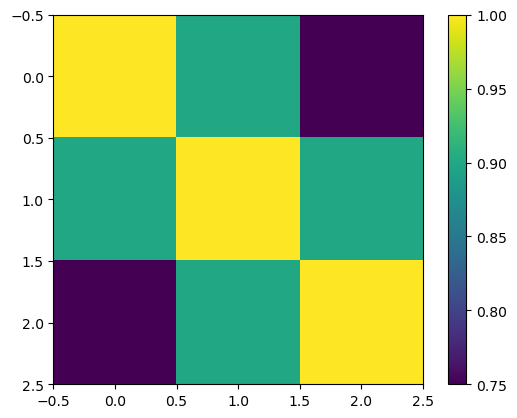

In [89]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

p = 3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();


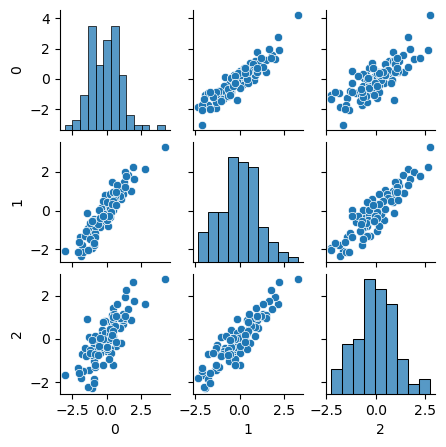

In [90]:
import seaborn
import pandas as pd
seaborn.pairplot(pd.DataFrame(x),height=1.5);

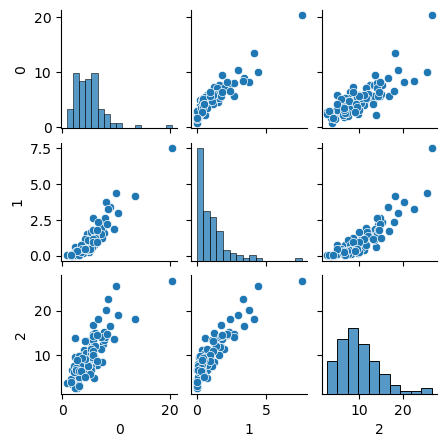

In [91]:
y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))

seaborn.pairplot(pd.DataFrame(y),height=1.5);

In [129]:
import pymc as pm
import arviz as az

with pm.Model() as copula:

    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:,0:1])
    y0_ = pm.Deterministic('y0_', 
            pm.Normal.icdf(
               pm.math.exp(pm.Gamma.logcdf(y0, alpha=p0, inv_beta=1)), 
                           mu=0, sigma=1))
    
    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:,1:2])
    y1_ = pm.Deterministic('y1_', 
            pm.Normal.icdf(
               pm.math.exp(pm.Exponential.logcdf(y1, mu=p1)), 
                           mu=0, sigma=1))

    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:,2:3])
    y2_ = pm.Deterministic('y2_', 
            pm.Normal.icdf(
               pm.math.exp(pm.ChiSquared.logcdf(y2, nu=p2)), 
                           mu=0, sigma=1))
    
    L,R,stds = pm.LKJCholeskyCov("R", n=3, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=3), 
                                 compute_corr=True)
    
    potential = pm.Potential("MVNeval", 
                             pm.logp(pm.MvNormal.dist(mu=0, cov=R),
                             pm.math.concatenate([y0_,y1_,y2_], axis=1)))
    
    idata = pm.sample()

# This probally produces a lot of warnings but it will run and provide inference


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] ... [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1960, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p0, p1, p2, R]


/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/scottschwartz/miniconda3/envs/PyMC/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op erfcinv does not

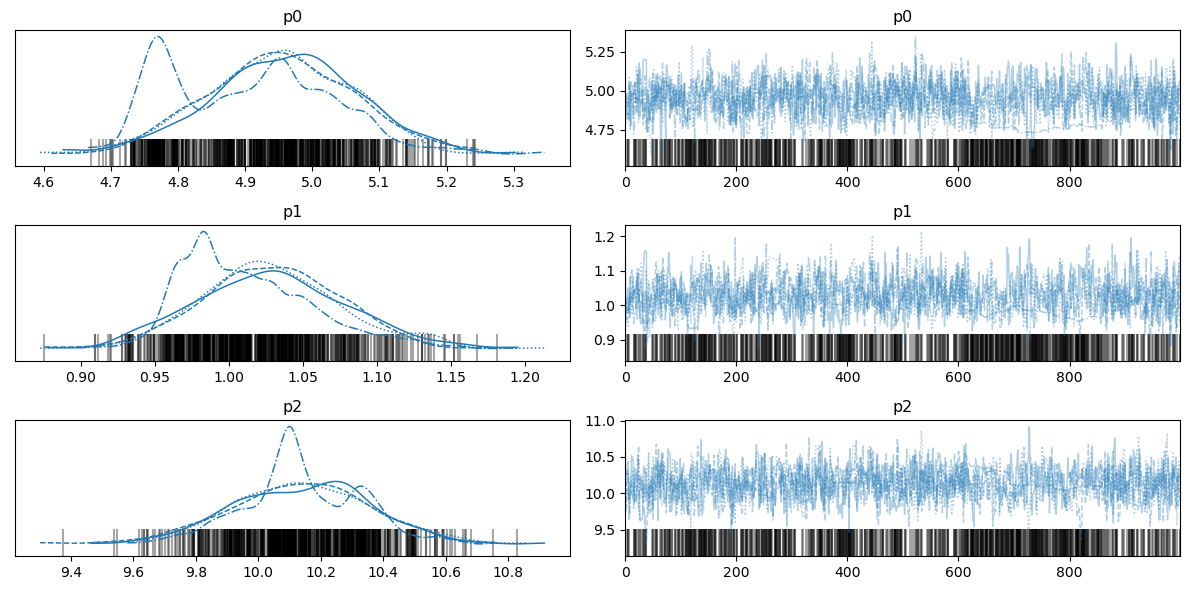

In [134]:
# Estimation is essentially correct
az.plot_trace(idata, var_names=['p0','p1','p2'])
plt.tight_layout()

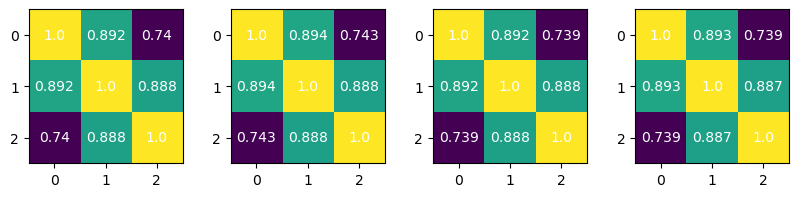

In [154]:
# Estimation is essentially correct
fig,ax = plt.subplots(1,4,figsize=(10,2))
for i,c in enumerate(list(idata.posterior['R_corr'].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(j,k,s=str(round(c[j,k],3)), 
                       color='w', va='center', ha='center')

### Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



### The Horseshoe prior

The [PyMC overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and [many](https://www.google.com/search?q=pymc+horseshoe&oq=pymc+horseshoe) other [resources](https://mellorjc.github.io/HorseshoePriorswithpymc3.html) provide ***Horseshoe prior*** [[1]](https://www.jstor.org/stable/25734098) [[2]](https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf) implementations 

| Half-Cauchy $\text{HC}_+(\xi)$ | Horseshoe Prior $\text{HSP}$ | Shrinkage $\kappa$ | Change of Variables|
|:-:|:-:|:-:|:-:|
|$$f(x \mid \xi) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \xi \left[1 + \left(\frac{x}{\xi}\right)^2\right]}$$|\begin{align*}w_i|\tau &\sim N(0, \sigma^{2}=\lambda_i^2\tau^2)\\\lambda_i &\sim HC_+(1)\\\tau &\sim HC_+(\tau_0)\end{align*}|\begin{align*}\kappa_{\lambda_i} ={}& 1/(1+\lambda_i^2)\\\lambda_i ={}& \sqrt{1/\kappa_{\lambda_i}-1}\\J_{\kappa_{\lambda_i}} ={}& \frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2} \end{align*}|\begin{align*}f(\kappa_{\lambda_i}) = {} & f\left(\lambda_i = \sqrt{1/\kappa_{\lambda_i}-1}\right)\\ {} & \times \underbrace{\frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2}}_{J_{\kappa_{\lambda_i}}} \end{align*}|



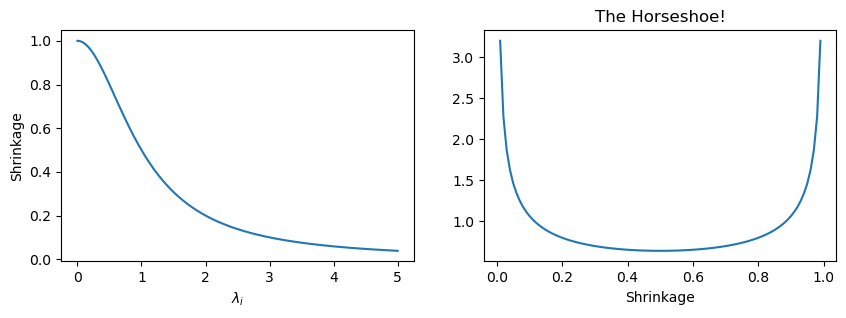

In [160]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
support = np.linspace(0,5,1000)
# shrnk = trans(spprt) = 1/(1+sprt**2)
shrinkage = 1/(1+support**2)
ax[0].plot(support, shrinkage)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$") 
# change of variables: 
# spprt = (1/shrnk-1)**0.5; E.g., 1/(1+.5**2), (1/.8-1)**0.5;
# jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0.01,.99,99)
ax[1].plot(shrinkage, 
           stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) * 
           .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2))
ax[1].set_title('The Horseshoe!')
ax[1].set_xlabel("Shrinkage");

# Answers

### Q1:

As introduced in https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html, below is the two pass approach:

In [97]:
import numpy as np

import pymc as pm
import arviz as az

import pytensor.tensor as pt

import matplotlib.pyplot as plt

from scipy.stats import (
    gamma, expon, chi2, norm
)

In [98]:
# Helper function to generate synthetic data.
def generate_copula_test_data(n: int) -> tuple[np.ndarray, np.ndarray]:
    a_cor = (np.ones((3, 3)) * 0.5 + np.eye(3) * 0.5)

    x = np.random.multivariate_normal(mean=np.zeros(3), cov=a_cor, size=n)
    
    y = np.column_stack([
        np.random.gamma(shape=2, scale=(1.0 / np.exp(x[:, 0])), size=n),
        np.random.exponential(scale=(1.0 / np.exp(x[:, 1])), size=n),
        np.random.chisquare(df=np.exp(x[:, 2]), size=n)
    ])

    return (x, y)

# Helper function to transform to standard normal space outside the model.
def transform_to_standard_normal(data, dist):
    cdf = dist.cdf(data)
    
    return norm.ppf(np.clip(cdf, 1e-10, 1 - 1e-10))

# Generating some data.
x_data, y_data = generate_copula_test_data(n=1000)

# Ensuring that there are no Inf or NaN values in the data.
y_data = np.nan_to_num(y_data, nan=np.nanmean(y_data), posinf=np.finfo(float).max, neginf=np.finfo(float).min)

# Estimating the marginal distributions.
with pm.Model() as marginal_model:
    p0 = pm.HalfNormal('p0', sigma=10)
    p1 = pm.HalfNormal('p1', sigma=10)
    p2 = pm.HalfNormal('p2', sigma=10)
    
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y_data[:, 0])
    y1 = pm.Exponential('y1', lam=p1, observed=y_data[:, 1])
    y2 = pm.ChiSquared('y2', nu=p2, observed=y_data[:, 2])
    
    trace_marginal = pm.sample(1000, return_inferencedata=True, target_accept=0.9)

# Extract posterior means of marginal parameters
p0_mean = az.summary(trace_marginal)['mean']['p0']
p1_mean = az.summary(trace_marginal)['mean']['p1']
p2_mean = az.summary(trace_marginal)['mean']['p2']

# Transform the data.
y0_transformed = transform_to_standard_normal(y_data[:, 0], gamma(a=p0_mean, scale=1))
y1_transformed = transform_to_standard_normal(y_data[:, 1], expon(scale=1 / p1_mean))
y2_transformed = transform_to_standard_normal(y_data[:, 2], chi2(df=p2_mean))

# Combine transformed variables into a fixed array.
y_transformed = np.column_stack([y0_transformed, y1_transformed, y2_transformed])

# Estimating copula parameters.
with pm.Model() as copula_model:
    # LKJ Cholesky covariance.
    chol, corr_matrix, stds = pm.LKJCholeskyCov('chol', n=3, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True)

    # Covariance matrix from Cholesky factor.
    cov_matrix = pm.Deterministic('cov', chol @ chol.T)

    # MvNormal likelihood with fixed observed data.
    pm.MvNormal('N', mu=np.zeros(3), cov=cov_matrix, observed=y_transformed)

    # Sample from copula model.
    trace_copula = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.69        7            140.75 draws/s   0:00:14   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.84        3            115.26 draws/s   0:00:17   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.57        3            99.68 draws/s    0:00:20   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.73        3            89.06 draws/s    0:00:22   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Now, we can view some diagnostic plots:

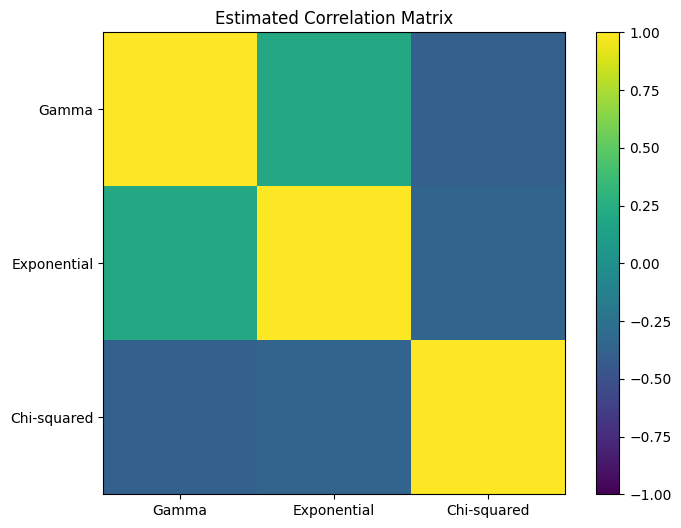

Estimated Gamma shape parameter: 2.0000
Estimated Exponential rate parameter: 0.6520
Estimated Chi-squared degrees of freedom: 0.6770
Estimated correlation matrix: [[ 1.          0.20787021 -0.38706187]
 [ 0.20787021  1.         -0.35081031]
 [-0.38706187 -0.35081031  1.        ]]


In [99]:
# Extract correlation matrix.
corr_matrix = np.zeros((3, 3))
corr_matrix[np.tril_indices(3)] = chol_samples
corr_matrix = corr_matrix + corr_matrix.T - np.diag(np.diag(corr_matrix))
np.fill_diagonal(corr_matrix, 1)

# Plot the estimated correlation matrix.
plt.figure(figsize=(8, 6))
plt.title('Estimated Correlation Matrix')

plt.imshow(corr_matrix, vmin=-1, vmax=1)
plt.colorbar()

plt.xticks([0, 1, 2], ['Gamma', 'Exponential', 'Chi-squared'])
plt.yticks([0, 1, 2], ['Gamma', 'Exponential', 'Chi-squared'])

plt.show()

# Viewing the estimated parameters.
print(f'Estimated Gamma shape parameter: {p0_mean:.4f}')
print(f'Estimated Exponential rate parameter: {p1_mean:.4f}')
print(f'Estimated Chi-squared degrees of freedom: {p2_mean:.4f}')

print(f'Estimated correlation matrix: {corr_matrix}')

A copula is a function that describes the dependence structure between random variables, independent of their marginal distributions. It allows for modeling multivariate distributions by separating the dependence structure from the individual marginal distributions.

In the example version, the marginal distributions and the copula are estimated simultaneously hence providing a one step approach. It uses a Gaussian copula to model the dependence structure between three different marginal distributions: Gamma, Exponential, and Chi-squared. 

By comparison, the two pass approach from PyMC separates the estimation into the following steps: first, the parameters of the marginal distributions are estimated. Next, the data from the first step is transformed and used to estimate the copula covariance parameter.

Both approaches transform the original data to a uniform space using the cumulative distribution functions (CDFs) of the marginal distributions, and then to a multivariate normal space using the inverse CDF of the standard normal distribution.

Arbitrary multivariate GLM regressions can be performed via copulas by initially defining appropriate marginal distributions for a set of response variables; a Gaussian copula can then be used to model the dependence structure between these marginal distributions. Then, estimate the parameters of both the marginal distributions and the copula, either simultaneously or with a two pass approach.

### Q2:

First, we shall perform multivariate Bayesian regression with spike and slab priors:

In [ ]:
# Helper function to generate synthetic data.
def generate_synthetic_data_spike_slab(n: int, m: int, p: int):
    x = np.random.randn(n, p)
    
    true_beta = np.array([1, 0, 0.5, 0, -0.8])

    y = np.dot(x, true_beta)[:, np.newaxis] + np.random.randn(n, m) * 0.1
    
    return x, y, true_beta

In [63]:
n, m, p = 100, 3, 5

# Generating some data with 100 samples, 3 response variables, and 5 predictors.
x_data, y_data, true_beta = generate_synthetic_data_spike_slab(n, m, p)

with pm.Model() as spike_slab_model:
    # Initializing spike and slab priors.
    tau = pm.HalfCauchy('tau', beta=1, shape=p)
    
    lambda_1 = pm.Laplace('lambda_1', mu=0., b=1., shape=(p, m))
    lambda_2 = pm.Laplace('lambda_2', mu=0., b=100., shape=(p, m))
    
    psi = pm.Bernoulli('psi', 0.5, shape=(p, m))
    
    beta = pm.Deterministic('beta', psi * lambda_1 + (1 - psi) * lambda_2)
    
    sigma = pm.HalfCauchy('sigma', beta=1)
    mu = pm.Deterministic('mu', pm.math.dot(x_data, beta))

    # Likelihood.
    likelihood = pm.MvNormal('likelihood', mu=mu, cov=sigma * np.eye(m), observed=y_data)

    # Inference.
    trace_ss = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    79            0.01        255          4.59 draws/s     0:07:15   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    2             0.04        127          8.81 draws/s     0:03:46   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    31            0.03        255          6.52 draws/s     0:05:06   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    6             0.02        127          9.02 draws/s     0:03:41   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 444 seconds.
/Users/lleytonariton/development/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Additionally, we also create the model with diffuse normal priors:

In [54]:
with pm.Model() as normal_model:
    # Initializing diffuse normal priors.
    beta = pm.Normal('beta', mu=0, sigma=10, shape=(p, m))
    
    sigma = pm.HalfCauchy('sigma', beta=1)
    mu = pm.Deterministic('mu', pm.math.dot(x_data, beta))

    # Likelihood.
    likelihood = pm.MvNormal('likelihood', mu=mu, cov=sigma * np.eye(m), observed=y_data)
    
    # Inference.
    trace_normal = pm.sample(1000, tune=1000, return_inferencedata=True)

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.73        7            216.82 draws/s   0:00:09   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.93        7            160.20 draws/s   0:00:12   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.60        7            138.19 draws/s   0:00:14   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.86        7            124.71 draws/s   0:00:16   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


We can compare the models via diagnostics.

/Users/lleytonariton/development/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/lleytonariton/development/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/lleytonariton/development/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/lleytonariton/development/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


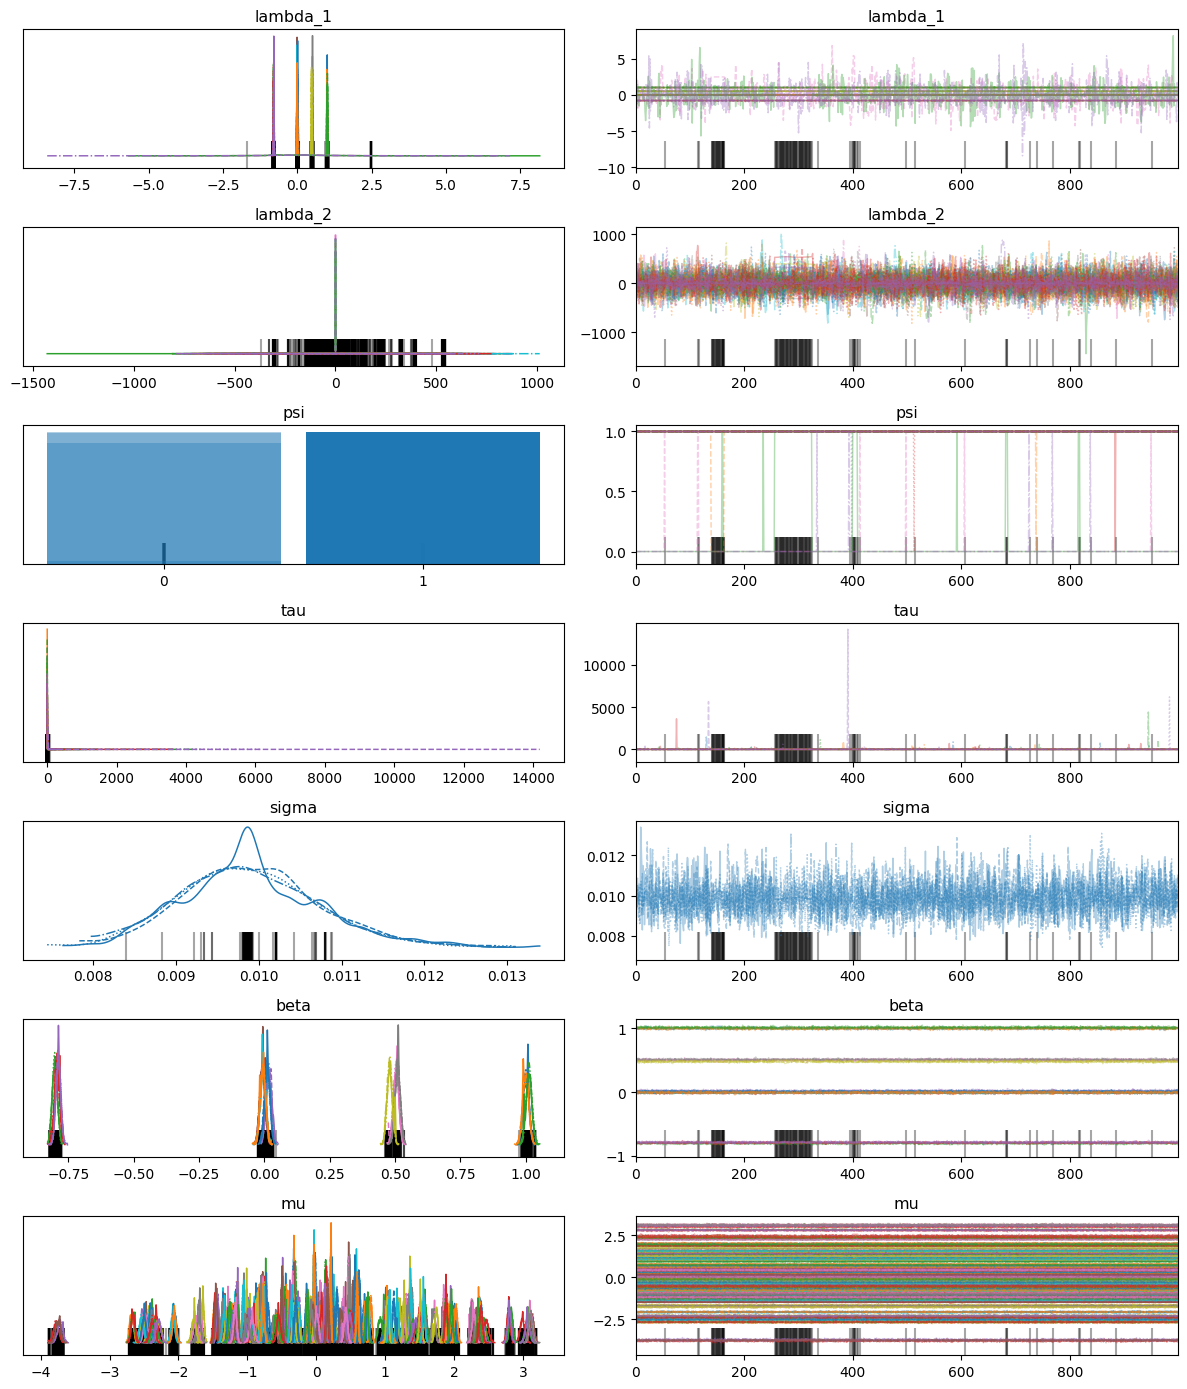

In [64]:
# Spike and Slab model summary and diagnostics.
az.summary(trace_ss)
az.plot_trace(trace_ss)

plt.tight_layout()
plt.show()

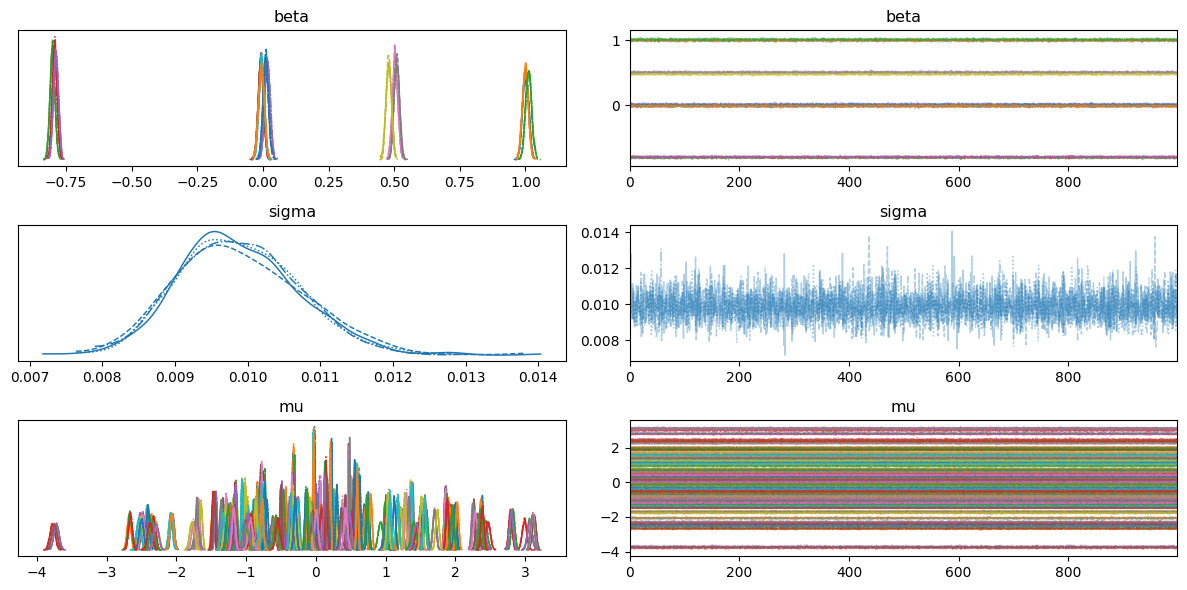

In [61]:
# Diffus normal priors model summary and diagnostics.
az.summary(trace_normal)
az.plot_trace(trace_normal)

plt.tight_layout()
plt.show()

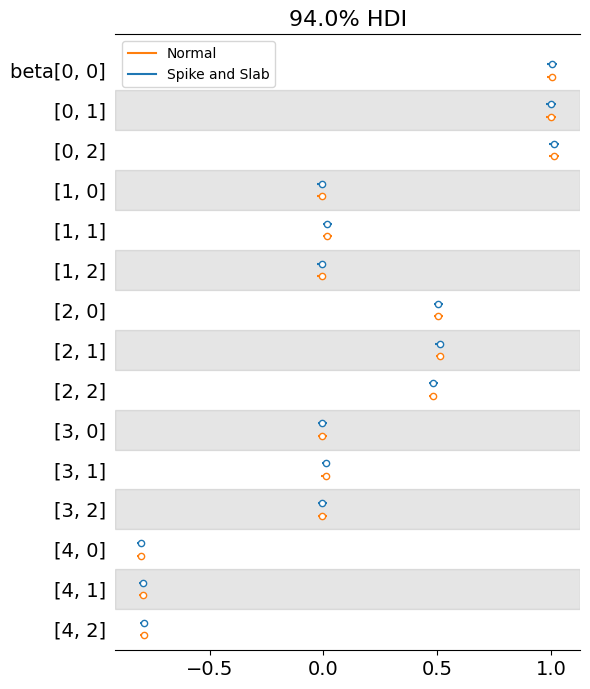

In [65]:
# Comparison between both models.
az.plot_forest([trace_ss, trace_normal], var_names=['beta'], combined=True, model_names=['Spike and Slab', 'Normal'])

plt.show()

### Q3:

Now, we will test variable selection by implementing the Horseshoe prior. As usual, we begin by creating a helper function to generate some toy dataset:

In [66]:
# Helper function to generate synthetic data for the Horseshoe prior experiment.
def generate_synthetic_horseshoe_data(n: int, m: int, p: int) -> tuple[np.ndarray]:
    x = np.random.randn(n, p)

    true_beta = np.array([1, 0, 0.5, 0, -0.8, 0, 0, 1.2, 0, -0.6])

    y = np.dot(x, true_beta[:, np.newaxis]) + np.random.randn(n, m) * 0.1
    
    return x, y, true_beta

In [71]:
n, m, p = 100, 3, 10

# Generating some data with 100 samples, 3 response variables, and 10 predictors.
x_data, y_data, true_beta = generate_synthetic_horseshoe_data(n, m, p)

with pm.Model() as horseshoe_model:
    # Initializing Horseshoe prior.
    tau = pm.HalfCauchy('tau', beta=1)
    
    c2 = pm.InverseGamma('c2', alpha=1, beta=1)
    
    lambda_tilde = pm.HalfCauchy('lambda_tilde', beta=1, shape=(p, m))
    lambda_sq = np.sqrt(c2 * (lambda_tilde ** 2) / (c2 + (tau ** 2) * (lambda_tilde ** 2)))
    
    beta = pm.Normal('beta', mu=0, sigma=(tau * lambda_sq), shape=(p, m))
    
    # Likelihood.
    sigma = pm.HalfCauchy('sigma', beta=1)
    mu = pm.Deterministic('mu', pm.math.dot(x_data, beta))
    
    likelihood = pm.MvNormal('likelihood', mu=mu, cov=sigma * np.eye(m), observed=y_data)
    
    # Inference.
    trace_hs = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    43            0.03        63           8.36 draws/s     0:03:59   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    35            0.06        127          7.13 draws/s     0:04:40   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    44            0.03        127          7.14 draws/s     0:04:39   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    33            0.05        63           7.95 draws/s     0:04:11   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 292 seconds.
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.


The model diagnostics can be seen below:

In [ ]:
# Diagnostics for Horseshoe prior model.
az.summary(trace_hs)
az.plot_trace(trace_hs)

plt.tight_layout()
plt.show()